In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
import xgboost as xgb
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold

# Imbalanced learning
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler

In [2]:
CAT_COLS = ['type', 'subtype', 'size_category', 'temperature', 'above_median_access_count', 'above_median_filesize']
NUM_COLS = ['stddev_access_date',
 'dt_last_access_date',
 'dt_second_last_access_date',
 'dt_third_last_access_date',
 'dt_fourth_last_access_date',
 'dt_fifth_last_access_date',
 'normalized_access_count',
 'normalized_filesize',
 'access_count_last_1_day',
 'access_count_last_3_days',
 'access_count_last_7_days',
 'access_count_last_15_days',
 'lifetime',
 'access_count',
 'read_data_per_second']

In [ ]:
df = pd.read_csv('/data/astro/scratch/msantama/tfm/data2.csv')

In [ ]:
df.columns = [col.replace('x.', '') if col.startswith('x.') else col for col in df.columns]

In [ ]:
# Each period rolls by 10 days, so, we will keep periods that are 20 days apart
df = df[df['period']% 2 == 0]
# We will predict for 20 days into the future, so we will drop the columns that are not needed
df.drop(columns=['y1', 'y3', 'pnfsid'], inplace=True)
# Reframe the periods to be again 0, 1, 2, ...
df['period'] = df['period'] // 2

In [ ]:
df['m_date_window'] = pd.to_datetime(df['m_date_window'], format='%Y-%m-%d')
df = df[df['m_date_window'].dt.year < 2023]
df.drop(columns=['m_date_window'], inplace=True)

In [ ]:
df[CAT_COLS] = df[CAT_COLS].astype(str)

# Statistical Tests

In [8]:
from scipy.stats import mannwhitneyu

results = []
for col in NUM_COLS:
    group_0 = df[df['y2'] == 0][col].dropna()
    group_1 = df[df['y2'] == 1][col].dropna()
    stat, p = mannwhitneyu(group_0, group_1, alternative='two-sided')
    results.append((col, stat, p))

# Sort by significance
u_test_results = pd.DataFrame(results, columns=['feature', 'statistic', 'p_value']).sort_values('p_value')


In [9]:
u_test_results.sort_values('statistic')

,feature,statistic,p_value
5,dt_fifth_last_access_date,1.451160e+11,0.000000e+00
4,dt_fourth_last_access_date,2.742409e+11,0.000000e+00
3,dt_third_last_access_date,6.843184e+11,0.000000e+00
2,dt_second_last_access_date,2.320121e+12,0.000000e+00
11,access_count_last_15_days,3.224797e+12,0.000000e+00
13,access_count,3.873705e+12,0.000000e+00
10,access_count_last_7_days,3.994686e+12,0.000000e+00
0,stddev_access_date,4.153845e+12,0.000000e+00
14,read_data_per_second,4.155664e+12,0.000000e+00
6,normalized_access_count,4.224930e+12,0.000000e+00


In [10]:
from scipy.stats import chi2_contingency

chi2_results = []
for col in CAT_COLS:
    contingency = pd.crosstab(df[col], df['y2'])
    chi2, p, _, _ = chi2_contingency(contingency)
    chi2_results.append((col, chi2, p))

chi2_df = pd.DataFrame(chi2_results, columns=['feature', 'chi2_statistic', 'p_value']).sort_values('p_value')

In [11]:
chi2_df.sort_values('chi2_statistic')

,feature,chi2_statistic,p_value
4,above_median_access_count,496.030426,6.945063e-110
5,above_median_filesize,1909.834064,0.000000e+00
2,size_category,2978.420820,0.000000e+00
3,temperature,9609.149318,0.000000e+00
0,type,25287.575309,0.000000e+00
1,subtype,141833.466051,0.000000e+00


# Very Naive Model

In [45]:
selected_features = [
    'dt_last_access_date',
    'lifetime',
    'access_count_last_1_day',
    'normalized_access_count',
    'subtype',
    'type',
    'temperature',
    'period',
    'y2'
]

In [46]:
CAT_FEATURES = ['subtype', 'type', 'temperature', 'period']
NUM_FEATURES = ['dt_last_access_date', 'lifetime', 'access_count_last_1_day', 'normalized_access_count']
SUPPORT_FEATURE = ['period']

In [47]:
df = df[selected_features]

In [48]:
df[CAT_FEATURES] = df[CAT_FEATURES].astype(str)

In [49]:
df_seen = df[df['period'].astype(int) < 7]
df_unseen = df[df['period'].astype(int) >= 7]

In [50]:
X = df_seen.drop(columns=['y2'])
y = df_seen['y2']

In [51]:
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), NUM_FEATURES),
    ('cat', OneHotEncoder(handle_unknown='ignore'), CAT_FEATURES)
])

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

base_model = LogisticRegression(class_weight='balanced', max_iter=1000)
calibrated_model = CalibratedClassifierCV(base_model, cv=3, method='sigmoid')  # Platt scaling

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('imputer', SimpleImputer(strategy='mean')),
    ('classifier', calibrated_model)
])

In [53]:
pipeline.fit(X, y)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['dt_last_access_date',
                                                   'lifetime',
                                                   'access_count_last_1_day',
                                                   'normalized_access_count']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['subtype', 'type',
                                                   'temperature',
                                                   'period'])])),
                ('imputer', SimpleImputer()),
                ('classifier',
                 CalibratedClassifierCV(cv=3,
                                        estimator=LogisticRegression(class_weight='balanced',
                                                                     max_iter=1000)))])

In [59]:
for p in range(5, 9):
    X_test = df_unseen[df_unseen['period'].astype(int) == p].drop(columns=['y2'])
    y_test = df_unseen[df_unseen['period'].astype(int) == p]['y2']

    if X_test.empty:
        X_test = df_seen[df_seen['period'].astype(int) == p].drop(columns=['y2'])
        y_test = df_seen[df_seen['period'].astype(int) == p]['y2']
    
    y_pred = pipeline.predict(X_test)

    y_probs = pipeline.predict_proba(X_test)[:, 1]
    threshold = 0.12
    y_pred = (y_probs >= threshold).astype(int)
    
    print(f"\n=== Evaluation for period {p} ===")
    print(f"Using threshold: {threshold:.2f}")
    print(classification_report(y_test, y_pred, digits=3))


=== Evaluation for period 5 ===
Using threshold: 0.12
              precision    recall  f1-score   support

           0      0.914     0.023     0.044    208085
           1      0.122     0.984     0.217     28722

    accuracy                          0.139    236807
   macro avg      0.518     0.504     0.131    236807
weighted avg      0.818     0.139     0.065    236807


=== Evaluation for period 6 ===
Using threshold: 0.12
              precision    recall  f1-score   support

           0      0.994     0.009     0.017    192238
           1      0.172     1.000     0.293     39558

    accuracy                          0.178    231796
   macro avg      0.583     0.504     0.155    231796
weighted avg      0.853     0.178     0.065    231796


=== Evaluation for period 7 ===
Using threshold: 0.12
              precision    recall  f1-score   support

           0      0.726     0.036     0.068    173320
           1      0.205     0.949     0.338     45539

    accuracy     

El problema amb aquest tipus de model és que necesita massa el threshold (el punt de tall), fins al punt que no dona un recall de 0 o de 100 segons el threshold que li donis. No podem basar-nos en cap tipus de model que ncessiti un threshold, ja que el percentatge de y va canviant amb la finestra d'observació. El que jo penso que haureim de fer és un model que sigui capaç d'apendre a reconeixer quin patró es dona en aquells fitxers que tenen un y=1 i que sigui capaç d'aplicar-lo a qualsevol dels períodes (finestres) sense "por" a equivacar-se. És per això, que jo penso que un mdoel tipus ranking és més adecuat. Aquest tipus de models posen una puntuació més alta a y=1 (quan creuen que el fitxer serà y=1) que a y=0, i després, nosaltres posem un threshold a posteriori segons el numero de fitxers que volem. El més segur és que en algun moment volguem veure quants fitxers queben a una cache i quan pesa cada fitxer i per tant li preguntem al model quins son els fitxers que tenen més probabilitat de y=1 i que pesin poc (o no).

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# ---- Settings ----
CAT_FEATURES = ['subtype', 'type', 'temperature', 'period']
NUM_FEATURES = ['dt_last_access_date', 'lifetime', 'access_count_last_1_day', 'normalized_access_count']
TOP_K_RATIO = 0.2  # Select top 20% predictions in each test period

# ---- 1. Split dataset ----
df_seen = df[df['period'].astype(int) < 7].copy()
df_unseen = df[df['period'].astype(int) >= 7].copy()

# ---- 2. Undersample y=0 ----
positive = df_seen[df_seen['y2'] == 1]
negative = df_seen[df_seen['y2'] == 0]
neg_sample = negative.sample(n=len(positive) * 2, random_state=42)
df_train = pd.concat([positive, neg_sample])

# ---- 3. Group by period ----
# ---- 3. Group by period with chunking for large groups ----
X_parts = []
y_parts = []
group_sizes = []

for period, group_df in df_train.groupby('period'):
    X_group = group_df.drop(columns=['y2'])
    y_group = group_df['y2']

    # Split large periods into chunks of max 5000 rows
    chunk_size = 5000
    for i in range(0, len(X_group), chunk_size):
        X_chunk = X_group.iloc[i:i+chunk_size]
        y_chunk = y_group.iloc[i:i+chunk_size]
        X_parts.append(X_chunk)
        y_parts.append(y_chunk)
        group_sizes.append(len(X_chunk))

# Reconstruct full dataset
X_train = pd.concat(X_parts, ignore_index=True)
y_train = pd.concat(y_parts, ignore_index=True)


# ---- 4. Preprocessing ----
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), NUM_FEATURES),
    ('cat', OneHotEncoder(handle_unknown='ignore'), CAT_FEATURES)
])

X_train_transformed = preprocessor.fit_transform(X_train)

# ---- 5. LightGBM Dataset with group ----
lgb_train = lgb.Dataset(X_train_transformed, label=y_train)
lgb_train.set_group(group_sizes)

params = {
    'objective': 'lambdarank',
    'metric': 'map',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'class_weight': 'balanced'
}

model = lgb.train(params, lgb_train, num_boost_round=100)

# ---- 6. Inference and Evaluation ----
from sklearn.metrics import classification_report

for p in range(7, 9):  # Test on future periods
    df_test = df_unseen[df_unseen['period'].astype(int) == p]
    if df_test.empty:
        continue

    X_test = df_test.drop(columns=['y2'])
    y_test = df_test['y2']

    X_test_transformed = preprocessor.transform(X_test)
    y_scores = model.predict(X_test_transformed)

    # --- Rank and select top K% ---
    k = int(len(y_scores) * TOP_K_RATIO)
    threshold_score = np.sort(y_scores)[-k]
    y_pred = (y_scores >= threshold_score).astype(int)

    print(f"\n=== Evaluation for period {p} ===")
    print(f"Top {TOP_K_RATIO*100:.1f}% selected (threshold score ≈ {threshold_score:.4f})")
    print(classification_report(y_test, y_pred, digits=3))


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# --- Select a test period ---
p = 7
df_test = df_unseen[df_unseen['period'].astype(int) == p].copy()
X_test = df_test.drop(columns=['y2'])
y_test = df_test['y2']

# Predict scores
X_test_transformed = preprocessor.transform(X_test)
y_scores = model.predict(X_test_transformed)

# Combine into a DataFrame
df_scores = df_test.copy()
df_scores['score'] = y_scores
df_scores['true_label'] = y_test.values

# Sort by score descending
df_scores = df_scores.sort_values(by='score', ascending=False).reset_index(drop=True)

# --- Precision@K calculation ---
top_k = 1000
df_top = df_scores.head(top_k)
df_top['cumulative_tp'] = df_top['true_label'].cumsum()
df_top['precision_at_k'] = df_top['cumulative_tp'] / (df_top.index + 1)

# --- Plot ---
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_top, x=df_top.index + 1, y='precision_at_k')
plt.xlabel("Top K Files")
plt.ylabel("Precision@K")
plt.title(f"Precision@K for Period {p} (Top 1000)")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Feature Summary for Top True Positives ---
true_positives_top = df_top[df_top['true_label'] == 1]
summary = true_positives_top[NUM_FEATURES + CAT_FEATURES].describe(include='all')

# Show feature summary
print(f"\nTop {len(true_positives_top)} true y=1 files in Top {top_k}:")
print(summary)

In [17]:
# Split the data into seen and unseen data
df_seen = df[df['period'] < 7]
df_unseen = df[df['period'] >= 7]

In [18]:
class DtLastAccessesImputer(BaseEstimator, TransformerMixin):
    """ Custom imputer for the lasts accesses (except the last one).
    It will impute the Nan values with the value of the lifetime column and
    create a new flag column that indicates that the value was imputed.
    """
    def fit(self, X, y=None):
        self.cols = [
            'dt_second_last_access_date',
            'dt_third_last_access_date',
            'dt_fourth_last_access_date',
            'dt_fifth_last_access_date'
        ]
        self.flag_cols = [col + '_imputed' for col in self.cols]
        self.feature_names_ = list(X.columns) + self.flag_cols
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.cols:
            imputed_flag = X_transformed[col].isna().astype(int)
            X_transformed[col] = X_transformed[col].fillna(X_transformed['lifetime'])
            X_transformed[col + '_imputed'] = imputed_flag
        return X_transformed

    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_)

In [19]:
# Let's create the pipeline
# 1. We will impute all the columns that are not categorical and not the dt ones
# 2. We will impute the dt columns with the lifetime column
# 3. We will scale the numerical columns
# 4. We will one-hot encode the categorical columns
# 6. We will under-sample the data to balance the classes
# 7. We will use an XGBoost classifier with early stopping
# Modified function - preprocessing only (no undersampling)
def create_preprocess_pipeline():
    # Define dt columns that need custom imputation
    dt_cols = ['dt_second_last_access_date', 'dt_third_last_access_date', 
               'dt_fourth_last_access_date', 'dt_fifth_last_access_date']
    
    # Numerical columns excluding dt and lifetime
    num_cols_simple = [col for col in NUM_COLS if col not in dt_cols and col != 'lifetime']
    
    # Define transformers
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean')),
        ('scaler', StandardScaler())
    ])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])
    
    dt_transformer = Pipeline(steps=[
        ('imputer', DtLastAccessesImputer()),
        ('scaler', StandardScaler())
    ])
    
    # Combine transformers (NO undersampling)
    preprocess_pipeline = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, CAT_COLS),
            ('num', numerical_transformer, num_cols_simple),
            ('dt', dt_transformer, dt_cols + ['lifetime'])  # Include lifetime for imputation
        ],
        remainder='drop'
    )
    
    return preprocess_pipeline

In [20]:
from sklearn.tree import DecisionTreeClassifier

In [21]:
# Training function with separate undersampling
def train_model_with_temporal_validation():
    print("Creating preprocessing pipeline...")
    preprocess_pipeline = create_preprocess_pipeline()
    
    # Use earlier periods for training, later for validation
    X_early = df_seen[df_seen['period'] < 6].drop(columns=['y2', 'period'])
    y_early = df_seen[df_seen['period'] < 6]['y2']
    X_late = df_seen[df_seen['period'] >= 6].drop(columns=['y2', 'period'])
    y_late = df_seen[df_seen['period'] >= 6]['y2']
    
    # Ensure categorical columns are strings
    X_early[CAT_COLS] = X_early[CAT_COLS].astype(str)
    X_late[CAT_COLS] = X_late[CAT_COLS].astype(str)
    
    # Preprocess
    X_early_processed = preprocess_pipeline.fit_transform(X_early)
    X_late_processed = preprocess_pipeline.transform(X_late)

    # Let's use a simple Decision Tree Classifier for having a quick model
    classifier = DecisionTreeClassifier(
        max_depth=5,          # Limit tree depth to prevent overfitting
        min_samples_split=50, # Require more samples before splitting a node
        min_samples_leaf=20,  # Require more samples in leaf nodes
        class_weight='balanced', # Handle class imbalance automatically
        random_state=42       # For reproducibility
    )   
    # Train with validation set (test data for early stopping)
    classifier.fit(
        X_early_processed, y_early,
        #eval_set=[(X_late_processed, y_late)],
    )
    
    return preprocess_pipeline, classifier

In [22]:
# Production-ready approach without undersampling
def create_production_pipeline(pipe, classifier):
    
    # Create sklearn Pipeline (no imblearn needed)
    full_pipeline = Pipeline([
        ('preprocess', pipe),
        ('classifier', classifier)
    ])
    
    return full_pipeline

In [23]:
prod_pipe, classifier = train_model_with_temporal_validation()

Creating preprocessing pipeline...


In [24]:
production_pipeline = create_production_pipeline(prod_pipe, classifier)


PROCESSING UNSEEN DATA FOR PERIOD 5:
⚠️ Unseen data missing for period 5, falling back to seen data.
Optimal threshold for period 5 (based on F1): 0.586

Classification report for period 5 (threshold=0.65):
              precision    recall  f1-score   support

           0       0.89      0.92      0.90    208085
           1       0.23      0.18      0.21     28722

    accuracy                           0.83    236807
   macro avg       0.56      0.55      0.56    236807
weighted avg       0.81      0.83      0.82    236807

Confusion matrix for period 5:
[[190829  17256]
 [ 23429   5293]]

Classification report with optimal threshold (0.586):
              precision    recall  f1-score   support

           0       0.93      0.76      0.84    208085
           1       0.26      0.62      0.37     28722

    accuracy                           0.74    236807
   macro avg       0.60      0.69      0.60    236807
weighted avg       0.85      0.74      0.78    236807



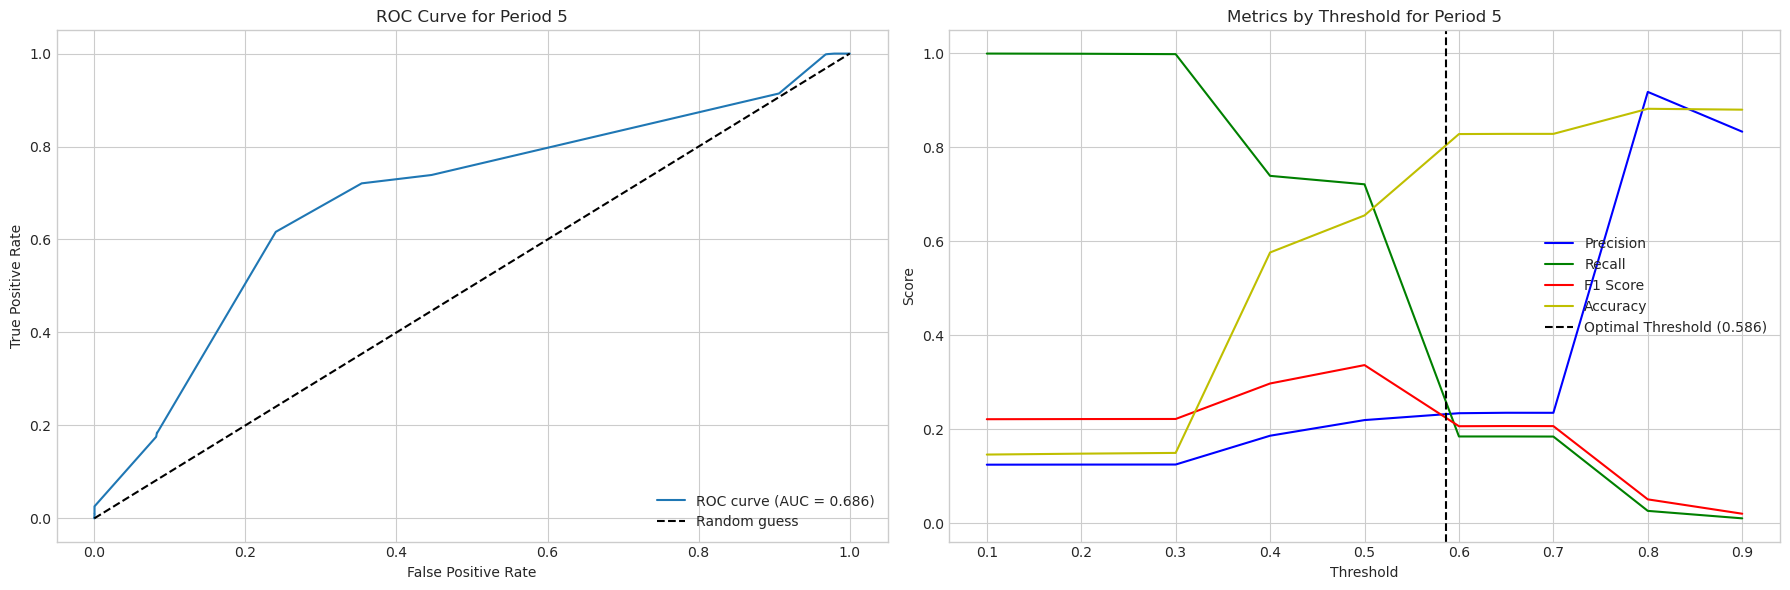


PROCESSING UNSEEN DATA FOR PERIOD 6:
⚠️ Unseen data missing for period 6, falling back to seen data.
Optimal threshold for period 6 (based on F1): 0.586

Classification report for period 6 (threshold=0.65):
              precision    recall  f1-score   support

           0       0.86      0.96      0.91    192238
           1       0.55      0.22      0.32     39558

    accuracy                           0.84    231796
   macro avg       0.70      0.59      0.61    231796
weighted avg       0.81      0.84      0.81    231796

Confusion matrix for period 6:
[[184920   7318]
 [ 30660   8898]]

Classification report with optimal threshold (0.586):
              precision    recall  f1-score   support

           0       0.88      0.84      0.86    192238
           1       0.35      0.43      0.39     39558

    accuracy                           0.77    231796
   macro avg       0.62      0.63      0.62    231796
weighted avg       0.79      0.77      0.78    231796



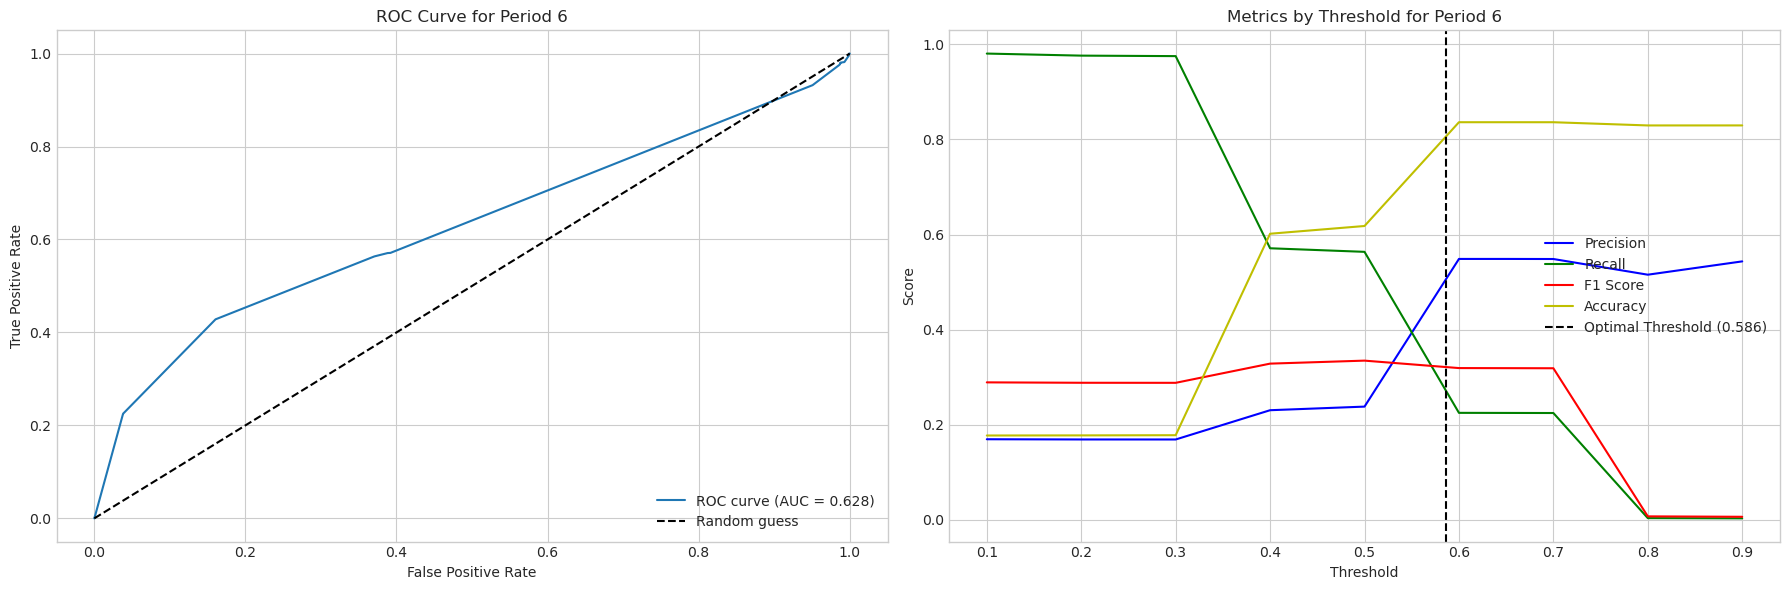


PROCESSING UNSEEN DATA FOR PERIOD 7:
Optimal threshold for period 7 (based on F1): 0.580

Classification report for period 7 (threshold=0.65):
              precision    recall  f1-score   support

           0       0.83      0.92      0.88    173320
           1       0.50      0.30      0.37     45539

    accuracy                           0.79    218859
   macro avg       0.67      0.61      0.62    218859
weighted avg       0.76      0.79      0.77    218859

Confusion matrix for period 7:
[[159816  13504]
 [ 31960  13579]]

Classification report with optimal threshold (0.580):
              precision    recall  f1-score   support

           0       0.85      0.64      0.73    173320
           1       0.29      0.56      0.39     45539

    accuracy                           0.63    218859
   macro avg       0.57      0.60      0.56    218859
weighted avg       0.73      0.63      0.66    218859



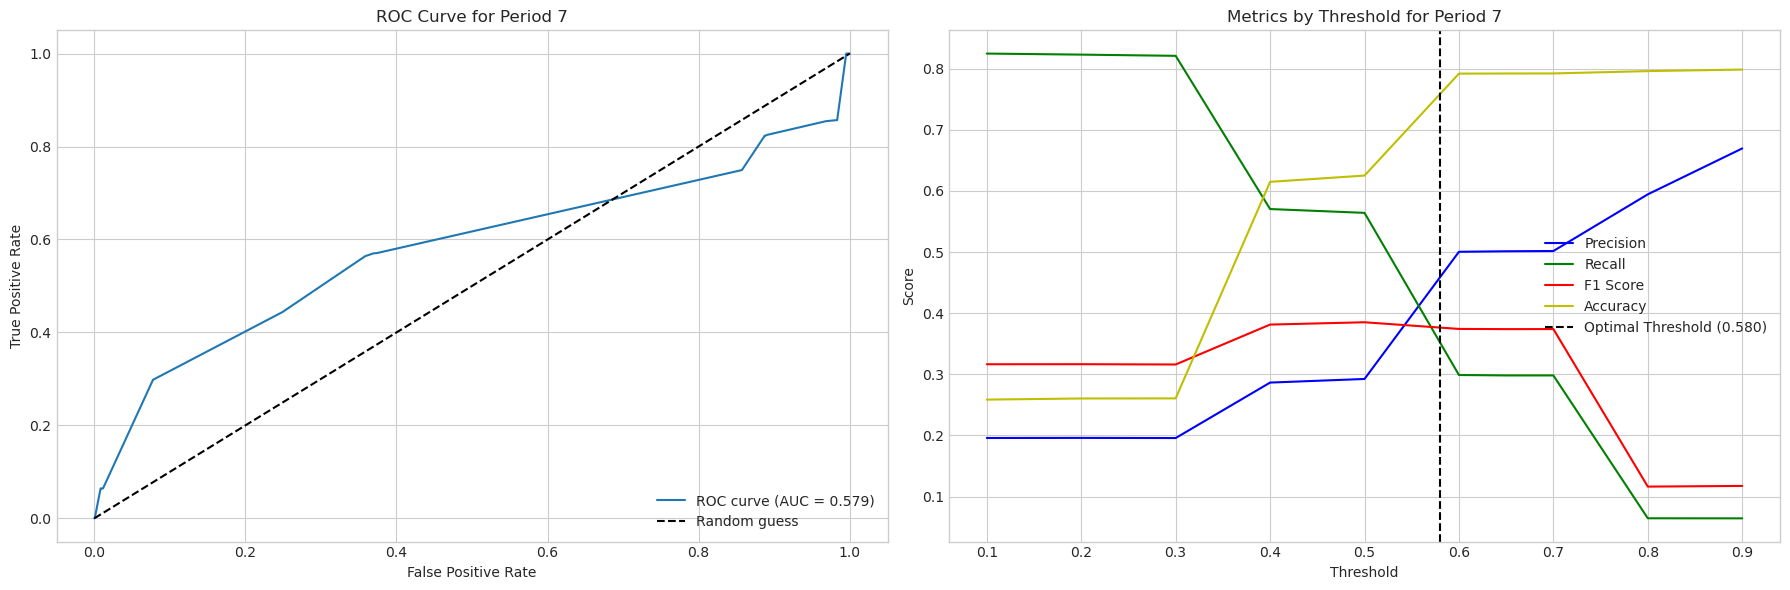


SUMMARY OF MODEL PERFORMANCE ACROSS PERIODS
   Period       AUC  Optimal Threshold
0       5  0.685836           0.586180
1       6  0.627933           0.586180
2       7  0.579194           0.579887


In [26]:
from sklearn.metrics import precision_recall_curve, f1_score, recall_score, precision_score, accuracy_score

# Evaluate model performance on unseen data with threshold optimization

# Set up plotting styles
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

# Test multiple thresholds
threshold_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.8, 0.9]

# Results tracking
period_results = {}

for period in range(5, 8):
    print(f"\n{'='*80}")
    print(f"PROCESSING UNSEEN DATA FOR PERIOD {period}:")
    print(f"{'='*80}")
    
    # Get data for this period
    df_unseen_period = df_unseen[df_unseen['period'] == period]
    if df_unseen_period.empty:
        print(f"⚠️ Unseen data missing for period {period}, falling back to seen data.")
        df_unseen_period = df_seen[df_seen['period'] == period]

    X = df_unseen_period.drop(columns=['y2', 'period'])
    y = df_unseen_period['y2']
    X[CAT_COLS] = X[CAT_COLS].astype(str)
    
    # Make predictions
    y_proba = production_pipeline.predict_proba(X)[:, 1]
    
    # Find the optimal threshold for F1 score
    precision, recall, thresholds = precision_recall_curve(y, y_proba)
    f1_scores = 2 * recall * precision / (recall + precision + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx] if optimal_idx < len(thresholds) else 0.5
    
    print(f"Optimal threshold for period {period} (based on F1): {optimal_threshold:.3f}")
    
    # Compare different thresholds
    threshold_metrics = []
    
    for threshold in threshold_range:
        y_pred = (y_proba >= threshold).astype(int)
        metrics = {
            'threshold': threshold,
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred, zero_division=0),
            'recall': recall_score(y, y_pred, zero_division=0),
            'f1': f1_score(y, y_pred, zero_division=0),
        }
        threshold_metrics.append(metrics)
    
    # Default threshold performance (0.65)
    default_pred = (y_proba >= 0.65).astype(int)
    print(f"\nClassification report for period {period} (threshold=0.65):\n{classification_report(y, default_pred)}")
    print(f"Confusion matrix for period {period}:\n{confusion_matrix(y, default_pred)}")
    
    # Optimal threshold performance
    optimal_pred = (y_proba >= optimal_threshold).astype(int)
    print(f"\nClassification report with optimal threshold ({optimal_threshold:.3f}):\n{classification_report(y, optimal_pred)}")
    
    # Store results
    period_results[period] = {
        'optimal_threshold': optimal_threshold,
        'auc': roc_auc_score(y, y_proba),
        'threshold_metrics': threshold_metrics
    }
    
    # Visualize results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
    
    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y, y_proba)
    ax1.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc_score(y, y_proba):.3f})')
    ax1.plot([0, 1], [0, 1], 'k--', label='Random guess')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title(f'ROC Curve for Period {period}')
    ax1.legend(loc='lower right')
    
    # Plot metrics across thresholds
    thresholds = [m['threshold'] for m in threshold_metrics]
    ax2.plot(thresholds, [m['precision'] for m in threshold_metrics], 'b-', label='Precision')
    ax2.plot(thresholds, [m['recall'] for m in threshold_metrics], 'g-', label='Recall')
    ax2.plot(thresholds, [m['f1'] for m in threshold_metrics], 'r-', label='F1 Score')
    ax2.plot(thresholds, [m['accuracy'] for m in threshold_metrics], 'y-', label='Accuracy')
    ax2.axvline(x=optimal_threshold, color='k', linestyle='--', 
                label=f'Optimal Threshold ({optimal_threshold:.3f})')
    ax2.set_xlabel('Threshold')
    ax2.set_ylabel('Score')
    ax2.set_title(f'Metrics by Threshold for Period {period}')
    ax2.legend(loc='center right')
    
    plt.tight_layout()
    plt.show()

# Summary of performance across periods
print("\n" + "="*50)
print("SUMMARY OF MODEL PERFORMANCE ACROSS PERIODS")
print("="*50)

summary_df = pd.DataFrame({
    'Period': list(period_results.keys()),
    'AUC': [results['auc'] for results in period_results.values()],
    'Optimal Threshold': [results['optimal_threshold'] for results in period_results.values()]
})
print(summary_df)

🔍 TOP 20 MOST PREDICTIVE FEATURES:
num__dt_last_access_date                : 0.3950
dt__dt_second_last_access_date          : 0.2424
num__access_count                       : 0.1329
dt__dt_fourth_last_access_date          : 0.0894
cat__subtype_MINIAODSIM                 : 0.0361
cat__temperature_cold                   : 0.0323
cat__temperature_cold-warm              : 0.0283
cat__subtype_AODSIM                     : 0.0192
dt__lifetime                            : 0.0075
cat__subtype_RAW-RECO                   : 0.0065
dt__dt_fifth_last_access_date           : 0.0048
num__normalized_access_count            : 0.0034
num__read_data_per_second               : 0.0022
cat__type_data                          : 0.0000
cat__subtype_GEN-SIM-DIGI-RAW           : 0.0000
cat__subtype_GEN-SIM-RAW                : 0.0000
cat__type_mc                            : 0.0000
cat__subtype_AOD                        : 0.0000
cat__size_category_small                : 0.0000
cat__size_category_medium         

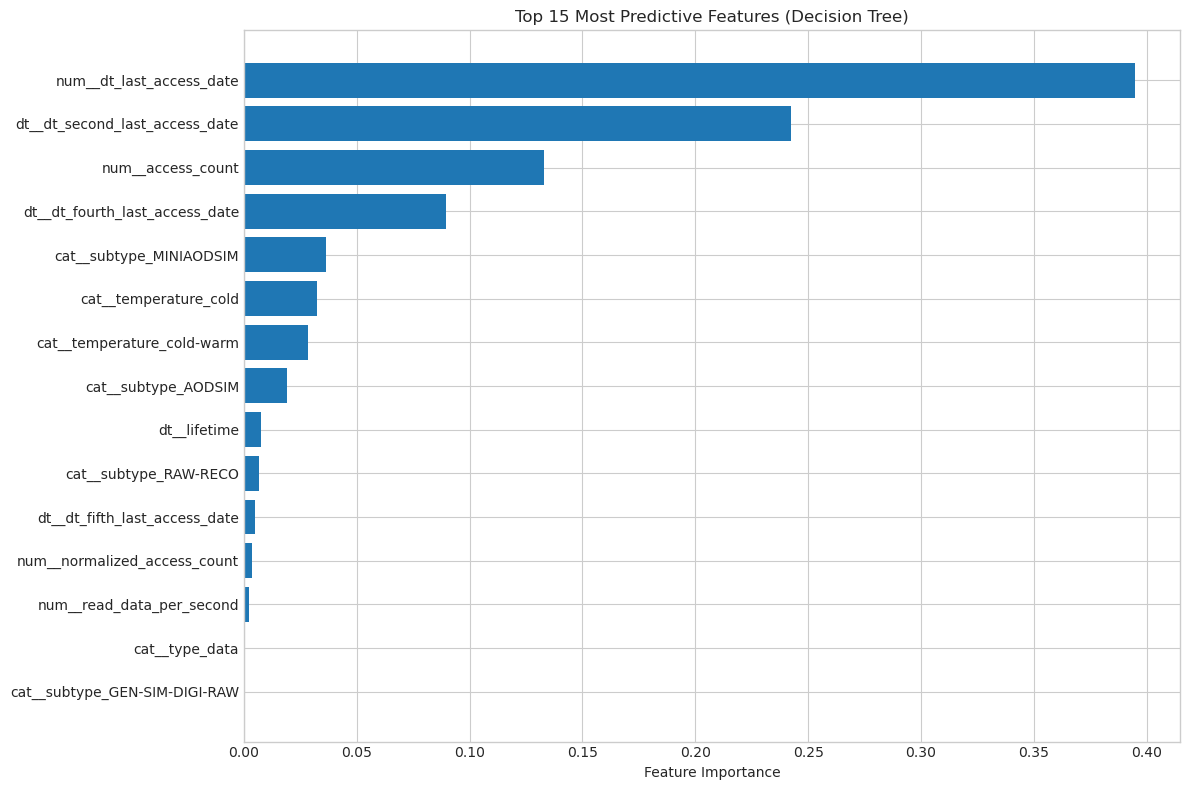

In [41]:
def analyze_decision_tree_features(pipeline, classifier):
    """Extract and visualize feature importance from Decision Tree"""
    
    # Get feature names after preprocessing
    preprocessor = pipeline.named_steps['preprocess']
    feature_names = preprocessor.get_feature_names_out()
    
    # Get feature importances
    importances = classifier.feature_importances_
    
    # Create DataFrame for easy analysis
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Display top features
    print("🔍 TOP 20 MOST PREDICTIVE FEATURES:")
    print("=" * 50)
    top_features = feature_importance_df#.head(20)
    for idx, row in top_features.iterrows():
        print(f"{row['feature'][:40]:40s}: {row['importance']:.4f}")
    
    # Visualize
    plt.figure(figsize=(12, 8))
    top_15 = feature_importance_df.head(15)
    plt.barh(range(len(top_15)), top_15['importance'])
    plt.yticks(range(len(top_15)), top_15['feature'])
    plt.xlabel('Feature Importance')
    plt.title('Top 15 Most Predictive Features (Decision Tree)')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

# Run feature analysis
feature_importance_df = analyze_decision_tree_features(production_pipeline, classifier)

In [11]:
# Training function with separate undersampling
def train_model_with_temporal_validation():
    print("Creating preprocessing pipeline...")
    preprocess_pipeline = create_preprocess_pipeline()
    
    # Use earlier periods for training, later for validation
    X_early = df_seen[df_seen['period'] < 14].drop(columns=['y2', 'period'])
    y_early = df_seen[df_seen['period'] < 14]['y2']
    X_late = df_seen[df_seen['period'] >= 14].drop(columns=['y2', 'period'])
    y_late = df_seen[df_seen['period'] >= 14]['y2']
    
    # Ensure categorical columns are strings
    X_early[CAT_COLS] = X_early[CAT_COLS].astype(str)
    X_late[CAT_COLS] = X_late[CAT_COLS].astype(str)
    
    # Preprocess
    X_early_processed = preprocess_pipeline.fit_transform(X_early)
    X_late_processed = preprocess_pipeline.transform(X_late)
    
    # Undersample only training data
    # undersampler = RandomUnderSampler(sampling_strategy=0.7, random_state=42)
    # X_early_resampled, y_early_resampled = undersampler.fit_resample(X_early_processed, y_early)
    
    classifier = xgb.XGBClassifier(
        device='cuda',
        tree_method='hist',
        max_depth=3,
        learning_rate=0.02,
        subsample=0.6,
        colsample_bytree=0.6,
        min_child_weight=10,
        reg_alpha=2.0,
        reg_lambda=10.0,
        scale_pos_weight=2.33,  # Handle remaining imbalance
        n_estimators=500,
        early_stopping_rounds=20,
        eval_metric='auc',
        random_state=42,
        verbosity=1
    )
    
    # Train with validation set (test data for early stopping)
    classifier.fit(
        X_early_processed, y_early,
        #eval_set=[(X_late_processed, y_late)],
        verbose=True
    )
    
    return preprocess_pipeline, classifier

In [12]:
production_pipeline, production_xg_classifier = train_model_with_temporal_validation()

Creating preprocessing pipeline...


ValueError: Must have at least 1 validation dataset for early stopping.

In [13]:
from lightgbm import LGBMClassifier, early_stopping, log_evaluation



def train_lightgbm_model():
    print("Creating LightGBM preprocessing pipeline...")
    preprocess_pipeline = create_lightgbm_pipeline()
    
    # Temporal split
    X_early = df_seen[df_seen['period'] < 14].drop(columns=['y2', 'period'])
    y_early = df_seen[df_seen['period'] < 14]['y2']
    X_late = df_seen[df_seen['period'] >= 14].drop(columns=['y2', 'period'])
    y_late = df_seen[df_seen['period'] >= 14]['y2']

    # Cast categorical features to string
    X_early[CAT_COLS] = X_early[CAT_COLS].astype(str)
    X_late[CAT_COLS] = X_late[CAT_COLS].astype(str)

    # Preprocess data
    X_early_processed = preprocess_pipeline.fit_transform(X_early)
    X_late_processed = preprocess_pipeline.transform(X_late)
    # Build classifier
    clf = LGBMClassifier(
        objective='binary',
        boosting_type='gbdt',
        n_estimators=1000,
        num_leaves=31,
        learning_rate=0.05,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=5,
        min_child_samples=100,
        reg_alpha=0.1,
        reg_lambda=0.1,
        scale_pos_weight=5.2,
        random_state=42,
        verbose=1
    )

    # Fit with early stopping
    clf.fit(
        X_early_processed, y_early,
        eval_set=[(X_late_processed, y_late)],
        eval_metric='recall',
        callbacks=[
            early_stopping(stopping_rounds=50),
            log_evaluation(period=100)
        ]
    )
    
    return preprocess_pipeline, clf

In [15]:
lgb_pipeline, lgb_model = train_lightgbm_model()

Creating LightGBM preprocessing pipeline...


NameError: name 'create_lightgbm_pipeline' is not defined

In [ ]:
production_pipeline = create_production_pipeline(lgb_pipeline, lgb_model)

In [ ]:
production_pipeline

In [ ]:
# 🔄 IMPROVED XGBoost Configuration (Your Current Model)
def create_improved_xgboost():
    """
    Improved XGBoost parameters based on EDA findings
    """
    # Keep your current preprocessing - it's good!
    preprocess_pipeline = create_preprocess_pipeline()
    
    # Improved XGBoost parameters
    improved_xgb = xgb.XGBClassifier(
        # GPU acceleration
        device='cuda',
        tree_method='hist',
        
        # Model complexity (slightly more complex given large dataset)
        max_depth=4,  # Increased from 3
        learning_rate=0.03,  # Slightly increased
        n_estimators=800,  # More trees
        
        # Regularization (good for overfitting prevention)
        subsample=0.8,  # Increased sampling
        colsample_bytree=0.8,  # Increased feature sampling
        min_child_weight=20,  # Increased for large dataset
        reg_alpha=1.0,  # Reduced L1
        reg_lambda=5.0,  # Reduced L2
        
        # Class imbalance handling
        scale_pos_weight=5.2,  # Exact ratio from EDA
        
        # Training control
        early_stopping_rounds=30,
        eval_metric='auc',
        random_state=42,
        verbosity=1
    )
    
    return preprocess_pipeline, improved_xgb

# 📊 Model Comparison Framework
def compare_models():
    """
    Compare different models on your data
    """
    from sklearn.metrics import roc_auc_score, classification_report
    
    # Prepare data
    X_early = df_seen[df_seen['period'] < 12].drop(columns=['y2', 'period', 'm_date_window'])
    y_early = df_seen[df_seen['period'] < 12]['y2']
    X_late = df_seen[df_seen['period'] >= 12].drop(columns=['y2', 'period', 'm_date_window'])
    y_late = df_seen[df_seen['period'] >= 12]['y2']
    
    X_early[CAT_COLS] = X_early[CAT_COLS].astype(str)
    X_late[CAT_COLS] = X_late[CAT_COLS].astype(str)
    
    results = {}
    
    # 1. Current XGBoost
    print("Training Current XGBoost...")
    current_pipe, current_xgb = train_model_with_temporal_validation()
    X_late_proc = current_pipe.transform(X_late)
    y_pred_current = current_xgb.predict_proba(X_late_proc)[:, 1]
    results['Current XGBoost'] = roc_auc_score(y_late, y_pred_current)
    
    # 2. Improved XGBoost
    print("Training Improved XGBoost...")
    improved_pipe, improved_xgb = create_improved_xgboost()
    X_early_proc = improved_pipe.fit_transform(X_early)
    X_late_proc = improved_pipe.transform(X_late)
    improved_xgb.fit(X_early_proc, y_early, 
                     eval_set=[(X_late_proc, y_late)], verbose=False)
    y_pred_improved = improved_xgb.predict_proba(X_late_proc)[:, 1]
    results['Improved XGBoost'] = roc_auc_score(y_late, y_pred_improved)
    
    print("\n🏆 MODEL COMPARISON RESULTS:")
    print("-" * 40)
    for model, auc in results.items():
        print(f"{model:20s}: AUC = {auc:.4f}")
    
    return results

# Uncomment to run comparison:
# model_results = compare_models()

In [ ]:
def create_lightgbm_pipeline():
    """
    LightGBM pipeline optimized for your data characteristics
    """
    # Minimal preprocessing for LightGBM
    # Define dt columns that need custom imputation
    dt_cols = ['dt_second_last_access_date', 'dt_third_last_access_date', 
               'dt_fourth_last_access_date', 'dt_fifth_last_access_date']
    
    # Numerical columns excluding dt and lifetime
    num_cols_simple = [col for col in NUM_COLS if col not in dt_cols and col != 'lifetime']
    
    # Simple numerical imputer (LightGBM handles missing values well)
    numerical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='mean'))
        # Note: No scaling needed for LightGBM
    ])
    
    # Categorical transformer - minimal processing for LightGBM
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ohe', OneHotEncoder())
        # Note: No encoding needed for LightGBM
    ])
    
    # Custom dt transformer (keep your current approach)
    dt_transformer = Pipeline(steps=[
        ('imputer', DtLastAccessesImputer())
        # Note: No scaling needed for LightGBM
    ])
    
    # Combine transformers
    preprocess_pipeline = ColumnTransformer(
        transformers=[
            ('cat', categorical_transformer, CAT_COLS),
            ('num', numerical_transformer, num_cols_simple),
            ('dt', dt_transformer, dt_cols + ['lifetime'])
        ],
        remainder='drop'
    )
    
    return preprocess_pipeline